# Introduction

This report focuses on analyzing document similarities, a crucial aspect of data analysis in areas like information retrieval and natural language processing. Emphasizing computational methods, we evaluate the efficiency and scalability of various algorithms.

Using "War and Peace" by Leo Tolstoy, we create a data matrix with rows representing word frequencies and columns indicating specific words. This matrix aids in our computational analysis and provides practical context.

The report addresses five key questions about algorithmic efficiency in document similarity. It examines the running times of cosine and Jaccard's similarity measures, including theoretical and empirical testing. We also explore worst-case scenarios in computing similarities between all document pairs, the effect of choosing different similarity measures, the benefits of parallel computing in this process, and the efficiency of Strassen’s method for matrix multiplication in calculating all-pairs cosine similarities.

Our aim is to offer a detailed analysis of these algorithms' running times, bridging theoretical computer science and practical data analysis, and contributing to the discussion on computational efficiency in textual data analysis.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
import time
from scipy.stats import linregress
import math
from scipy.optimize import curve_fit
import joblib
import json
import re

In [3]:
df = pd.read_csv("data2023.csv", index_col = 0)

### PART 1

In the first part, we will evaluate the efficiency of cosine similarity calculations, a crucial technique in data science and machine learning for analyzing the relationship between high-dimensional data vectors. Our methodology includes two steps: first, developing a custom cosine similarity function for a deeper understanding of its computational aspects, and second, utilizing the NumPy library for the same purpose. After that, we will compare the performance of our custom function with NumPy's optimized routines by progressively increasing vector sizes, simulating real-world data complexity.

In [4]:
# Function to calculate the dot product of two vectors
def dot(v1, v2):
    total = 0
    for i in range(0, len(v1)): total += v1[i] * v2[i]
    return total

# Function to calculate cosine similarity with a custom implementation
def customCosine(v1, v2):
    dotProduct = dot(v1, v2)
    magnitudeV1 = math.sqrt(dot(v1, v1))
    magnitudeV2 = math.sqrt(dot(v2, v2))
    if magnitudeV1 == 0 or magnitudeV2 == 0: return 0
    return dotProduct / (magnitudeV1 * magnitudeV2)

In [5]:
# Generating a list of sample sizes
sampleSizeList = np.linspace(0, len(df), 101, dtype = int)[1:]
dfSampleSize = [[df.iloc[:i, 0], df.iloc[:i, 1]] for i in sampleSizeList]

In [6]:
# Function to measure the time taken for cosine similarity calculations on different sample sizes
def sampleSizeCustomCosineElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in range(10): customCosine(i[0].values, i[1].values)
        endTime = time.time()
        elapsedTime = (endTime - startTime) / 10
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

In [7]:
# Function to plot elapsed time against sample size and perform linear regression
def plotSampleSizeElapsedTime(sampleSizeList, elapsedTimeList, label):
    slope, intercept, rValue, pValue, stdErr = linregress(sampleSizeList, elapsedTimeList)
    estimatedTime = slope * sampleSizeList + intercept
    plt.plot(sampleSizeList, estimatedTime, color = 'red', label = 'Estimated Regression Line')
    scatterPlotData = {"Sample Size": sampleSizeList, "Elapsed Time (s)": elapsedTimeList}
    scatterPlotDataframe = pd.DataFrame(scatterPlotData)
    sns.scatterplot(x = "Sample Size", y = "Elapsed Time (s)", data = scatterPlotDataframe, label = 'Actual Time')
    plt.title(label + ' Calculation Time Depending On Sample Size')
    plt.legend()
    plt.show()
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R_squared: {rValue ** 2}")
    print(f"std_err: {stdErr}")

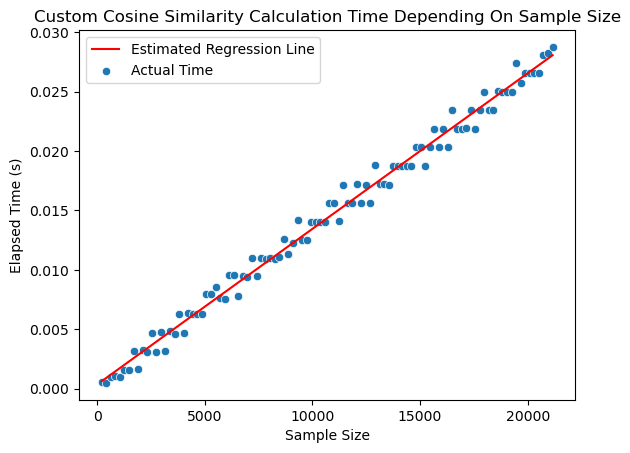

Slope: 1.309364403572811e-06
Intercept: 0.00035891819050968936
R_squared: 0.9909306182384394
std_err: 1.265361772433432e-08
Total Elapsed Time: 1.4346596240997314 seconds


In [38]:
# Calculating and plotting custom cosine similarity times
elapsedTimeListSampleSizeCustomCosine = sampleSizeCustomCosineElapsedTime(dfSampleSize)
plotSampleSizeElapsedTime(sampleSizeList, elapsedTimeListSampleSizeCustomCosine, "Custom Cosine Similarity")
totalElapsedTimeSampleSizeCustomCosine = sum(elapsedTimeListSampleSizeCustomCosine)
print("Total Elapsed Time: " + str(totalElapsedTimeSampleSizeCustomCosine) + " seconds")

In [9]:
# Function to calculate cosine similarity using NumPy
def numPyCosine(v1, v2):
    return np.sum(v1 * v2) / (norm(v1) * norm(v2))

In [10]:
# Function to measure the time taken for NumPy cosine similarity calculations on different sample sizes
def sampleSizeNumPyCosineElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in range(1000): numPyCosine(i[0].values, i[1].values)
        endTime = time.time()
        elapsedTime = (endTime - startTime) / 1000
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

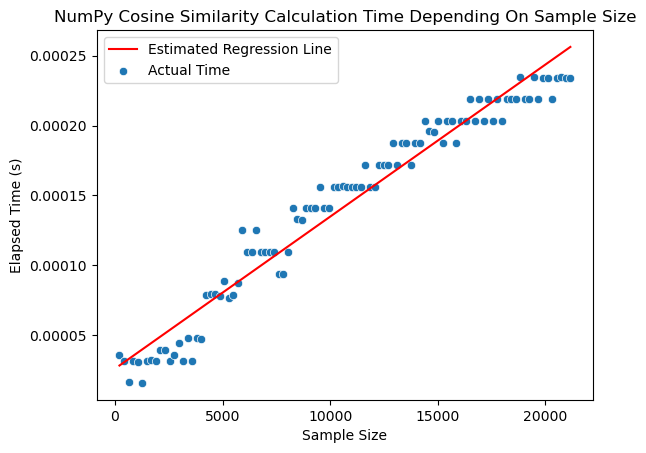

Slope: 1.0895433051519098e-08
Intercept: 2.5795000421285693e-05
R_squared: 0.9556579085598712
std_err: 2.370763957800122e-10
Total Elapsed Time: 0.014218873262405392 seconds


In [43]:
# Calculating and plotting NumPy cosine similarity times
elapsedTimeListSampleSizeNumPyCosine = sampleSizeNumPyCosineElapsedTime(dfSampleSize)
plotSampleSizeElapsedTime(sampleSizeList, elapsedTimeListSampleSizeNumPyCosine, "NumPy Cosine Similarity")
totalElapsedTimeSampleSizeNumPyCosine = sum(elapsedTimeListSampleSizeNumPyCosine)
print("Total Elapsed Time: " + str(totalElapsedTimeSampleSizeNumPyCosine) + " seconds")

In [12]:
# Function to compare elapsed times between two methods
def compareElapsedTime(method, elapsedTimeList1, elapsedTimeList2, xTicks, function1, function2, xLabel):
    if function2 == "Multiprocess Custom Cosine":
        extractedElapsedTimeList2 = elapsedTimeList2[0]
        totalElapsedTime2 = elapsedTimeList2[1]
        dfPlot = pd.DataFrame({method: xTicks, function1: elapsedTimeList1, function2: extractedElapsedTimeList2})
    else: dfPlot = pd.DataFrame({method: xTicks, function1: elapsedTimeList1, function2: elapsedTimeList2})
    sns.lineplot(x = method, y = 'value', hue = "variable", data = pd.melt(dfPlot, [method]))
    plt.ylabel('Elapsed Time (s)')
    plt.legend(title = 'Functions')
    plt.title(method + " Elapsed Time Comparison")
    plt.xlabel(xLabel)
    if method == "All Pairs": plt.xticks(xTicks)
    plt.show()
    print(function1 + " Total Elapsed Time: " + str(sum(elapsedTimeList1)) + " seconds")
    if function2 == "Multiprocess Custom Cosine": print(function2 + " Total Elapsed Time: " + str(totalElapsedTime2) + " seconds")
    else: print(function2 + " Total Elapsed Time: " + str(sum(elapsedTimeList2)) + " seconds")

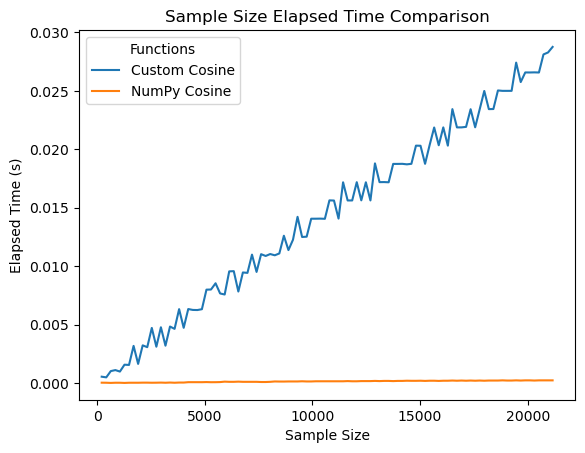

Custom Cosine Total Elapsed Time: 1.4346596240997314 seconds
NumPy Cosine Total Elapsed Time: 0.014218873262405392 seconds


In [44]:
# Comparing the elapsed times of custom and NumPy cosine similarities
compareElapsedTime("Sample Size",
                   elapsedTimeListSampleSizeCustomCosine,
                   elapsedTimeListSampleSizeNumPyCosine,
                   sampleSizeList,
                   "Custom Cosine",
                   "NumPy Cosine",
                   "Sample Size")

Upon concluding our examination of cosine similarity calculation efficiencies, we observed distinct performance differences between a custom function and the optimized NumPy library. Both approaches showed linear time complexity (O(n)), but NumPy's implementation was markedly faster. This highlights the advantages of using optimized libraries, especially in large-scale data processing.

### PART 2

In the second part, we will set out to assess the computational efficiency of the Jaccard similarity algorithm, a standard method in data science for comparing data sets. Our focus is to examine how the computation time of this algorithm varies with the increase in vector sizes. We will calculate Jaccard similarity for pairs of vectors with progressively growing sizes. By recording the time taken for each calculation, we aim to determine the algorithm's time complexity and understand its scalability and efficiency in processing varying data volumes.

In [14]:
# Function to calculate the total sum of values in a dictionary
def makeTotal(dict1):
    total = 0
    for item in dict1: total += dict1[item]
    return total

# Function to calculate the Jaccard similarity between two dictionaries
def jaccard(dict1, dict2):
    intersection = {}
    for item in dict1.keys():
        if item in dict2.keys(): intersection[item] = min(dict1[item], dict2[item])
    intersectionTotal = makeTotal(intersection)
    union = makeTotal(dict1) + makeTotal(dict2) - intersectionTotal
    if union == 0: return 0
    return intersectionTotal / union

In [15]:
# Function to measure the time taken for Jaccard similarity calculations on different sample sizes
def sampleSizeJaccardElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        jaccard(dict(i[0]), dict(i[1]))
        endTime = time.time()
        elapsedTime = endTime - startTime
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

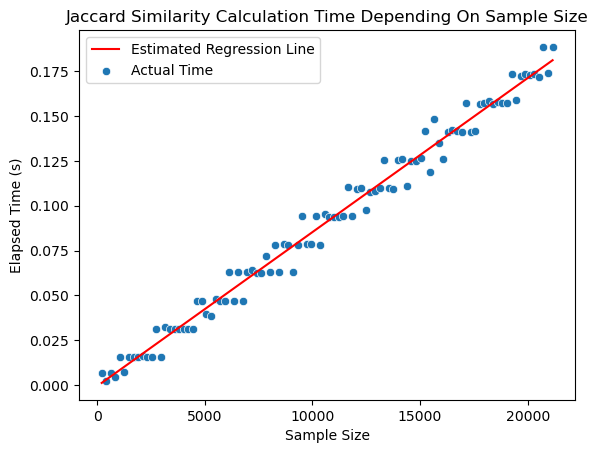

Slope: 8.586697448353118e-06
Intercept: -0.0005886546105501322
R_squared: 0.9857912614155221
std_err: 1.0413540322783838e-07
Total Elapsed Time: 9.114131689071655 seconds


In [47]:
# Calculating and plotting Jaccard similarity times
elapsedTimeListSampleSizeJaccard = sampleSizeJaccardElapsedTime(dfSampleSize)
plotSampleSizeElapsedTime(sampleSizeList, elapsedTimeListSampleSizeJaccard, "Jaccard Similarity")
totalElapsedTimeSampleSizeJaccard = sum(elapsedTimeListSampleSizeJaccard)
print("Total Elapsed Time: " + str(totalElapsedTimeSampleSizeJaccard) + " seconds")

Our experiment has successfully provided insights into the performance of the Jaccard similarity algorithm. The results confirmed a linear time complexity (O(n)) for the Jaccard similarity algorithm, as indicated by the consistent increase in computation time proportional to the vector sizes. This was further substantiated by the linear regression analysis. The total elapsed time for all calculations also reinforced our understanding of the algorithm's scalability.

### PART 3

This part aims to evaluate and compare the computational efficiency of cosine and Jaccard similarity calculations, two widely used methods in data science for measuring the similarity between vectors. Our approach will involve calculating these similarities for progressively increasing numbers of vector pairs from a dataset. Specifically, we will examine how the computation time for each method scales as we calculate similarities for an expanding set of vector pairs, following a pattern of triangular numbers sequence, which grows quadratically. By tracking the elapsed time for each method across different iterations, we aim to determine the time complexity of these algorithms and evaluate which method is more efficient in handling an increasing number of vector comparisons.

In [17]:
dfCut = df[:5000]
numOfTotalPairs = len(dfCut.columns)
numOfTotalPairsList = range(1, numOfTotalPairs)
dfAllPairs = []

# Creating pairs of columns from the DataFrame for similarity calculations
for i in range(2, numOfTotalPairs + 1):
    temp = []
    for j in range(i - 1):
        for k in range(j + 1, i):
            df1 = dfCut.iloc[:, j]
            df2 = dfCut.iloc[:, k]
            newDf = pd.concat([df1, df2], axis = 1, join = 'inner')
            temp.append(newDf)
    dfAllPairs.append(temp)

In [18]:
# Function to measure the time taken for custom cosine similarity calculations for all pairs
def allPairsCustomCosineElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in i: customCosine(j.iloc[:, 0].values, j.iloc[:, 1].values)
        endTime = time.time()
        elapsedTime = endTime - startTime
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

In [19]:
# Function to fit a quadratic curve
def quadraticCurve(x, a, b, c):
    return a * x**2 + b * x + c

In [20]:
# Function to plot elapsed time against the number of pairs and fit a quadratic curve
def plotPairSizeElapsedTime(elapsedTimeList, label):
    PairSizeArray = np.arange(1, len(elapsedTimeList) + 1)
    popt = curve_fit(quadraticCurve, PairSizeArray, elapsedTimeList)[0]
    plt.plot(PairSizeArray, quadraticCurve(PairSizeArray, *popt), color = 'red', label = 'Fitted Quadratic Curve')
    scatterPlotData = {"Number Of Pairs Used": PairSizeArray, "Elapsed Time (s)": elapsedTimeList}
    scatterPlotDataframe = pd.DataFrame(scatterPlotData)
    sns.scatterplot(x = "Number Of Pairs Used", y = "Elapsed Time (s)", data = scatterPlotDataframe, label = 'Actual Time')
    plt.title(label + ' Calculation Time Depending On Pair Size')
    plt.xticks(PairSizeArray)
    plt.legend()
    plt.show()
    print(f"Steepness: {popt[0]}")
    print(f"Slope: {popt[1]}")
    print(f"Intercept: {popt[2]}")

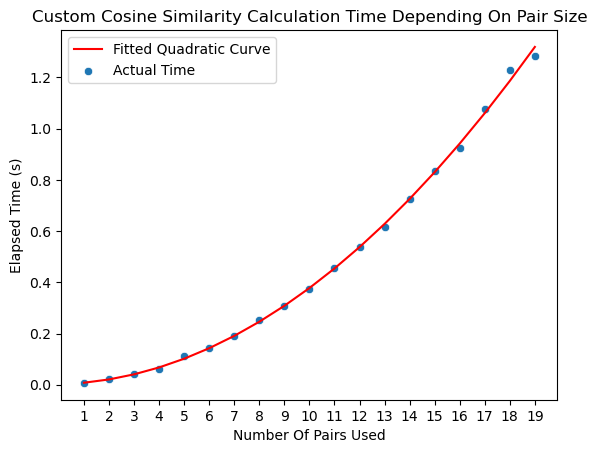

Steepness: 0.003530558521100291
Slope: 0.002251987540860534
Intercept: 0.0019890742875766643
Total Elapsed Time: 9.186149597167969 seconds


In [48]:
# Calculating and plotting elapsed time for custom cosine similarity for all pairs
elapsedTimeListAllPairsCustomCosine = allPairsCustomCosineElapsedTime(dfAllPairs)
plotPairSizeElapsedTime(elapsedTimeListAllPairsCustomCosine, "Custom Cosine Similarity")
totalElapsedTimeAllPairsCustomCosine = sum(elapsedTimeListAllPairsCustomCosine)
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsCustomCosine) + " seconds")

In [22]:
# Function to measure the time taken for Jaccard similarity calculations for all pairs
def allPairsJaccardElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in i: jaccard(dict(j.iloc[:, 0]), dict(j.iloc[:, 1]))
        endTime = time.time()
        elapsedTime = endTime - startTime
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

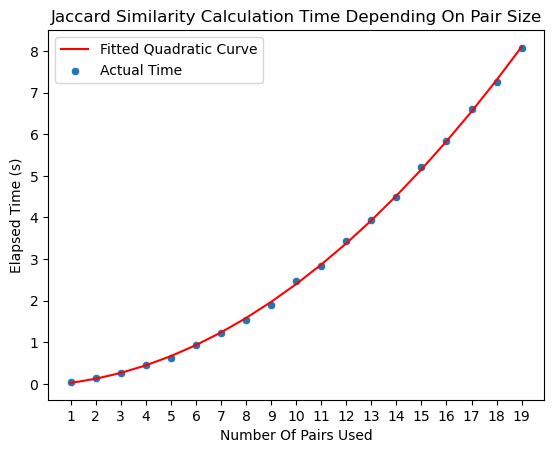

Steepness: 0.020538290743777
Slope: 0.03792371861443922
Intercept: -0.03569159271777167
Total Elapsed Time: 57.25694441795349 seconds


In [49]:
# Calculating and plotting elapsed time for Jaccard similarity for all pairs
elapsedTimeListAllPairsJaccard = allPairsJaccardElapsedTime(dfAllPairs)
plotPairSizeElapsedTime(elapsedTimeListAllPairsJaccard, "Jaccard Similarity")
totalElapsedTimeAllPairsJaccard = sum(elapsedTimeListAllPairsJaccard)
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsJaccard) + " seconds")

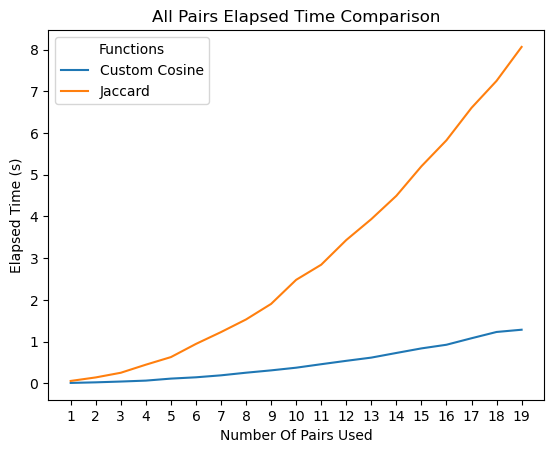

Custom Cosine Total Elapsed Time: 9.186149597167969 seconds
Jaccard Total Elapsed Time: 57.25694441795349 seconds


In [50]:
# Comparing the elapsed times of custom cosine and Jaccard similarities for all pairs
compareElapsedTime("All Pairs",
                   elapsedTimeListAllPairsCustomCosine,
                   elapsedTimeListAllPairsJaccard,
                   numOfTotalPairsList,
                   "Custom Cosine",
                   "Jaccard",
                   "Number Of Pairs Used")

Our experiment comparing the computational efficiency of cosine and Jaccard similarity calculations revealed that both algorithms exhibit a quadratic time complexity (O(n^2)) as the number of vector pairs increased. Notably, the custom cosine similarity function consistently demonstrated faster performance compared to the Jaccard similarity function across various iterations. This finding is crucial for large-scale data science applications, emphasizing the importance of selecting efficient computational methods when dealing with rapidly increasing numbers of comparisons.

### PART 4

This part will focus on optimizing the computation of cosine similarity, a key metric in vector analysis within data analytics. The challenge lies in managing the increasing computational load as datasets grow larger. To address this, we will investigate two computational methods: a conventional single-threaded approach and an innovative multi-threaded approach. Our aim is to evaluate the performance and efficiency improvements offered by parallel processing, especially important for handling large quantities of vector pairs.

In [25]:
# Function to calculate custom cosine similarity with multiprocessing
def customCosineMultiprocess(df):
    startTime = time.time()
    for i in df: customCosine(i.iloc[:, 0].values, i.iloc[:, 1].values)
    endTime = time.time()
    elapsedTime = endTime - startTime
    return elapsedTime

In [26]:
# Function to measure the time taken for custom cosine similarity calculations using multiprocessing
def allPairsCustomCosineMultiprocessElapsedTime(df):
    elapsedTimeList = joblib.Parallel(n_jobs = len(df))(joblib.delayed(customCosineMultiprocess)(dfSub) for dfSub in df)
    return elapsedTimeList

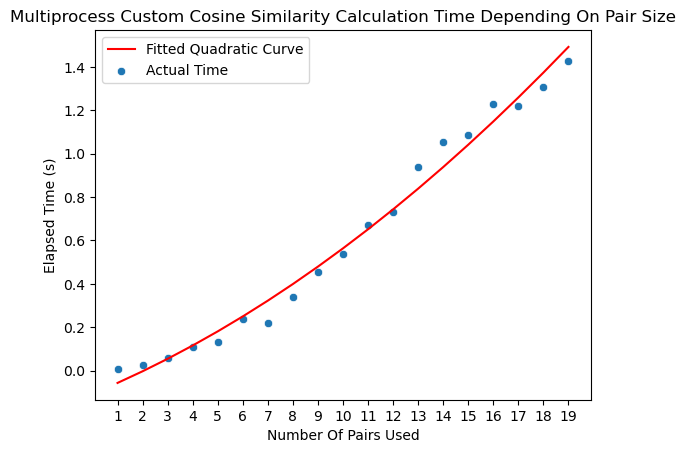

Steepness: 0.0019037434270863065
Slope: 0.048034908157019836
Intercept: -0.10698165054835082
Total Elapsed Time: 2.398057699203491 seconds


In [51]:
# Measuring and plotting the total elapsed time for multiprocessing-based custom cosine similarity calculation
startTime = time.time()
elapsedTimeListAllPairsMultiprocessCustomCosine = allPairsCustomCosineMultiprocessElapsedTime(dfAllPairs)
endTime = time.time()
totalElapsedTimeAllPairsMultiprocessCustomCosine = endTime - startTime
plotPairSizeElapsedTime(elapsedTimeListAllPairsMultiprocessCustomCosine, "Multiprocess Custom Cosine Similarity")
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsMultiprocessCustomCosine) + " seconds")

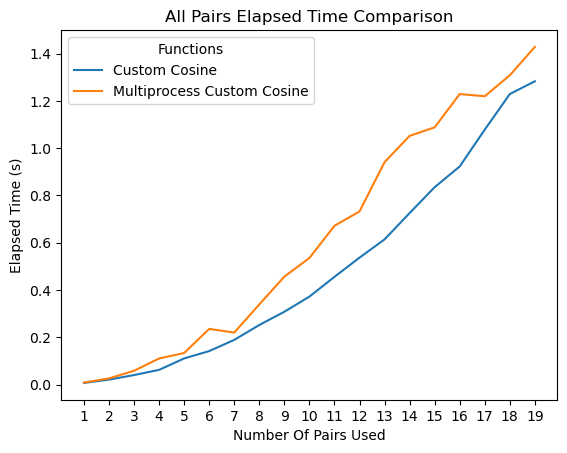

Custom Cosine Total Elapsed Time: 9.186149597167969 seconds
Multiprocess Custom Cosine Total Elapsed Time: 2.398057699203491 seconds


In [52]:
# Comparing the elapsed times of single-process and multi-process custom cosine similarities for all pairs
compareElapsedTime("All Pairs",
                   elapsedTimeListAllPairsCustomCosine,
                   [elapsedTimeListAllPairsMultiprocessCustomCosine, totalElapsedTimeAllPairsMultiprocessCustomCosine],
                   numOfTotalPairsList,
                   "Custom Cosine",
                   "Multiprocess Custom Cosine",
                   "Number Of Pairs Used")

Upon implementing and evaluating both the single-threaded and multi-threaded methods for calculating cosine similarity, we observed a clear distinction in performance. The multi-threaded approach, leveraging parallel processing, demonstrated a significant reduction in computation time compared to the single-threaded method. This was particularly evident as the size of the dataset and the number of vector pairs increased exponentially. These findings highlight the efficacy of parallel processing in managing large-scale data computations, offering a substantial improvement in speed and efficiency.

### Part 5

In the last part, we will investigate the efficiency of calculating cosine similarity between vectors using two methods: a custom cosine function and Strassen's matrix multiplication algorithm. Our focus is to assess these methods' performance as the number of vector pairs increases following a triangular series. This approach will simulate the growing computational demands encountered in data analysis and machine learning, providing insights into the effectiveness of traditional versus matrix-based computational strategies in real-world scenarios.

In [29]:
dfStrassenCut = df[:5]
dfAllPairsStrassenCut = []

# Generating all possible pairs of columns from the DataFrame
for i in range(2, numOfTotalPairs + 1):
    temp = []
    for j in range(i - 1):
        for k in range(j + 1, i):
            df1 = dfStrassenCut.iloc[:, j]
            df2 = dfStrassenCut.iloc[:, k]
            newDf = pd.concat([df1, df2], axis = 1, join = 'inner')
            temp.append(newDf)
    dfAllPairsStrassenCut.append(temp)

In [30]:
# Function to split a matrix into four equal parts
def splitMatrix(A):
    rows, cols = A.shape
    rowSplit, colSplit = rows // 2, cols // 2
    return A[:rowSplit, :colSplit], A[:rowSplit, colSplit:], A[rowSplit:, :colSplit], A[rowSplit:, colSplit:]

# Function for Strassen's matrix multiplication algorithm
def strassenMatrixMultiplication(A, B):
    if len(A) == 1: return A * B
    A11, A12, A21, A22 = splitMatrix(A)
    B11, B12, B21, B22 = splitMatrix(B)
    M1 = strassenMatrixMultiplication(A11 + A22, B11 + B22)
    M2 = strassenMatrixMultiplication(A21 + A22, B11)
    M3 = strassenMatrixMultiplication(A11, B12 - B22)
    M4 = strassenMatrixMultiplication(A22, B21 - B11)
    M5 = strassenMatrixMultiplication(A11 + A12, B22)
    M6 = strassenMatrixMultiplication(A21 - A11, B11 + B12)
    M7 = strassenMatrixMultiplication(A12 - A22, B21 + B22)
    C11 = M1 + M4 - M5 + M7
    C12 = M3 + M5
    C21 = M2 + M4
    C22 = M1 - M2 + M3 + M6
    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
    return C

# Function to round up a matrix size to the next power of 2
def nextPowerOf2(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

# Function to pad a matrix to the next power of 2 size
def padMatrixToPowerOf2(A):
    size = nextPowerOf2(max(A.shape))
    paddedMatrix = np.zeros((size, size))
    paddedMatrix[:A.shape[0], :A.shape[1]] = A
    return paddedMatrix

In [31]:
# Function to calculate cosine similarity using Strassen's matrix multiplication
def strassenCustomCosine(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    A = np.diag(v1)
    B = np.diag(v2)
    paddedA = padMatrixToPowerOf2(A)
    paddedB = padMatrixToPowerOf2(B)
    dotProduct = np.trace(strassenMatrixMultiplication(paddedA, paddedB))
    normV1 = math.sqrt(np.trace(strassenMatrixMultiplication(paddedA, paddedA)))
    normV2 = math.sqrt(np.trace(strassenMatrixMultiplication(paddedB, paddedB)))
    if normV1 == 0 or normV2 == 0: return 0
    return dotProduct / (normV1 * normV2)

In [32]:
# Function to measure the time taken for Strassen's custom cosine similarity calculations for all pairs
def allPairsStrassenCustomCosineElapsedTime(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for j in i: strassenCustomCosine(j.iloc[:, 0].values, j.iloc[:, 1].values)
        endTime = time.time()
        elapsedTime = endTime - startTime
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

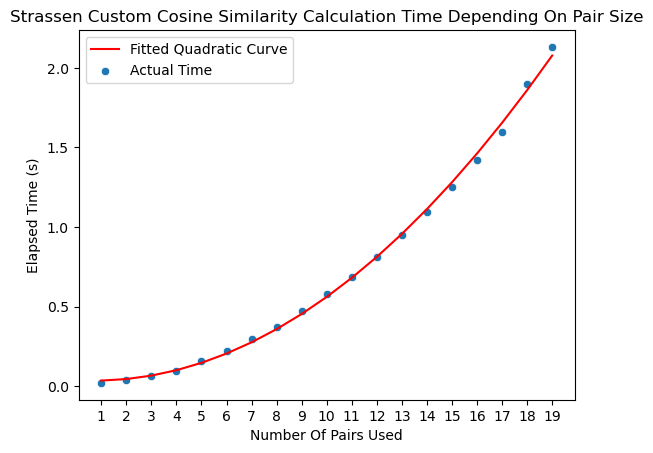

Steepness: 0.006111587566253629
Slope: -0.008815829590526514
Intercept: 0.038452605096813475
Total Elapsed Time: 14.1512131690979 seconds


In [53]:
# Calculating and plotting elapsed time for Strassen's custom cosine similarity
elapsedTimeListAllPairsStrassenCustomCosine = allPairsStrassenCustomCosineElapsedTime(dfAllPairsStrassenCut)
plotPairSizeElapsedTime(elapsedTimeListAllPairsStrassenCustomCosine, "Strassen Custom Cosine Similarity")
totalElapsedTimeAllPairsStrassenCustomCosine = sum(elapsedTimeListAllPairsStrassenCustomCosine)
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsStrassenCustomCosine) + " seconds")

In [34]:
# Function to measure the time taken for custom cosine similarity calculations for all pairs with additional iterations for accuracy
def allPairsCustomCosineElapsedTimeV2(df):
    elapsedTimeList = []
    for i in df:
        startTime = time.time()
        for k in range(20):
            for j in i: customCosine(j.iloc[:, 0].values, j.iloc[:, 1].values)
        endTime = time.time()
        elapsedTime = (endTime - startTime) / 20
        elapsedTimeList.append(elapsedTime)
    return elapsedTimeList

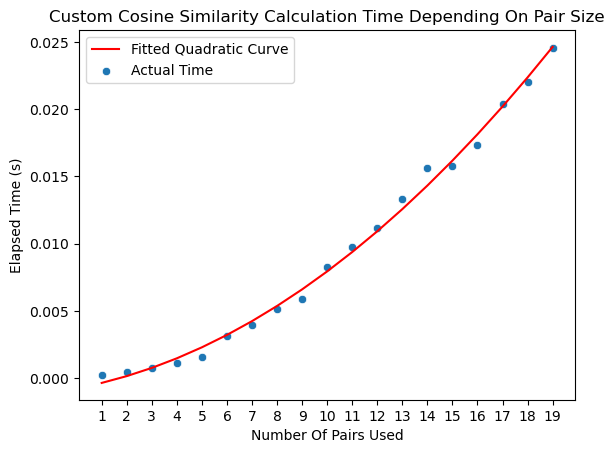

Steepness: 5.1922152211184976e-05
Slope: 0.00035113735568488466
Intercept: -0.0007723513772923712
Total Elapsed Time: 0.18028913736343383 seconds


In [54]:
# Calculating and plotting elapsed time for custom cosine similarity
elapsedTimeListAllPairsCustomCosineV2 = allPairsCustomCosineElapsedTimeV2(dfAllPairsStrassenCut)
plotPairSizeElapsedTime(elapsedTimeListAllPairsCustomCosineV2, "Custom Cosine Similarity")
totalElapsedTimeAllPairsCustomCosineV2 = sum(elapsedTimeListAllPairsCustomCosineV2)
print("Total Elapsed Time: " + str(totalElapsedTimeAllPairsCustomCosineV2) + " seconds")

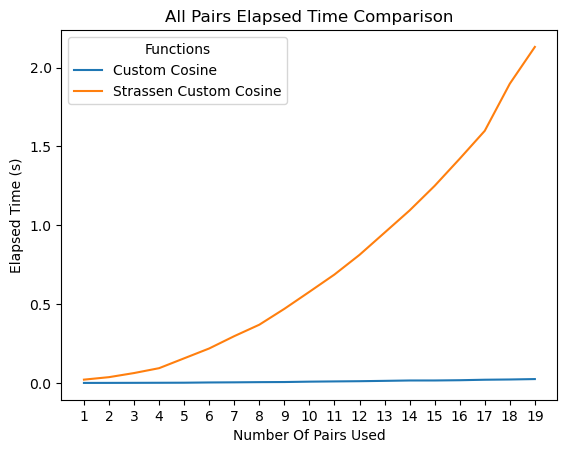

Custom Cosine Total Elapsed Time: 0.18028913736343383 seconds
Strassen Custom Cosine Total Elapsed Time: 14.1512131690979 seconds


In [55]:
# Comparing the elapsed times of Strassen's and custom cosine similarities for all pairs
compareElapsedTime("All Pairs",
                   elapsedTimeListAllPairsCustomCosineV2,
                   elapsedTimeListAllPairsStrassenCustomCosine,
                   numOfTotalPairsList,
                   "Custom Cosine",
                   "Strassen Custom Cosine",
                   "Number Of Pairs Used")

Our analysis comparing the custom cosine method with Strassen's matrix multiplication revealed an unexpected result: the conventional cosine method outperformed Strassen's algorithm. This finding highlights a key computational principle: advanced algorithms, while theoretically efficient, may not always offer practical speed advantages in certain applications. The exponential increase in computation time with the growing number of vector pairs underscores the challenges in handling large datasets and emphasizes the need to carefully choose the most suitable algorithm based on the specific data structure and application context.

# Conclusion

This study explores document similarity measures through the lens of "War and Peace" by Leo Tolstoy, structured around five key questions to assess algorithmic efficiency and effectiveness. It reveals the critical role of algorithm implementation, as shown by the performance differences between numpy's dot product and custom implementations in computing cosine similarities. Jaccard's similarity measure presents contrasting computational characteristics, offering new perspectives on algorithm efficiency in text analysis.

The research further examines scalability, particularly in calculating all-pairs similarities, uncovering how different similarity measures vary in efficiency under diverse data scenarios. The use of parallel computing in implementing these measures shows potential for significantly enhancing computational speed.

Additionally, applying Strassen’s method for matrix multiplication in cosine similarity calculations provides a practical application of theoretical computer science concepts, offering insights into algorithm scalability and optimization.

In summary, the report highlights the complex interplay of theoretical and empirical considerations in algorithm development for document similarity analysis. These findings are vital for future research and the creation of more efficient data analysis tools in various disciplines, emphasizing a balanced approach to evaluating and implementing algorithms for large-scale text analysis.

In [37]:
def countWordsInText(text):
    words = re.findall(r'\b\w+\b', text)
    return len(words)

def countWordsInNotebook(notebookPath):
    totalWordCount = 0
    with open(notebookPath, 'r', encoding = 'utf-8') as file: notebook = json.load(file)
    for cell in notebook['cells']:
        if cell['cell_type'] in ['markdown', 'raw']:
            text = ''.join(cell['source'])
            totalWordCount += countWordsInText(text)
    return totalWordCount

notebookPath = 'C:\\Users\\arsen\\OneDrive\\Masaüstü\\arsen\\AlgorithmicDataScience\\ArsenDuzgun_AlgorithmicDataScience_FinalReport.ipynb'
wordCount = countWordsInNotebook(notebookPath)
print(f"Total Word Count: {wordCount}")

Total Word Count: 1183
